In [ ]:
# -*- coding: utf-8 -*-
from oandapyV20 import API
from oandapyV20.exceptions import V20Error
from oandapyV20.endpoints.pricing import PricingStream
import oandapyV20.endpoints.orders as orders
import oandapyV20.endpoints.instruments as instruments

import json
import datetime
import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta

import time

get_ipython().run_line_magic('matplotlib', 'inline')
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
import pickle
import math
import glob

#自分のアカウント、トークンをセット
accountID = "101-009-16415310-001"
access_token = '860c2d2dbbcd01b6d95939b6af6b5981-8664724ce0870220c55161d704137df6'

api = API(access_token=access_token, environment="practice")
        
# Oandaからcandleデータを取得する。
def getCandleDataFromOanda(instrument, api, date_from, date_to, granularity):
    params = {
        "from": date_from.isoformat(),
        "to": date_to.isoformat(),
        "granularity": granularity,
    }
    r = instruments.InstrumentsCandles(instrument=instrument, params=params)
    return api.request(r)

def oandaJsonToPythonList(JSONRes):
    
    data = []
    for res in JSONRes['candles']:
        temp = [((datetime.datetime.fromisoformat(res['time'][:19]))+datetime.timedelta(hours=+9)).strftime('%Y-%m-%d %H:%M')]#indexとなる時間を追加
        temp.extend([res['volume'],
            res['mid']['o'],
            res['mid']['h'],
            res['mid']['l'],
            res['mid']['c'],
            ])
        data.append(temp)
    return data

def logarism(x):
    return math.log(x)


def get_now_data(time, period_Days, money='USD_JPY', foot = 'D', back_days = 0):
    all_data = []
    time = time.replace(hour=7, minute=0, second=0, microsecond=0)
    #入力された日の当日の7時
    
    NY = datetime.timedelta(hours=-14)
    back = datetime.timedelta(days=-back_days)
    
    date_to = time + NY + datetime.timedelta(seconds=0) + back
    date_from = date_to + datetime.timedelta(days=-period_Days)
    
    ret = getCandleDataFromOanda(money, api, date_from, date_to, foot)
    month_data = oandaJsonToPythonList(ret)#取得したデータを格納

    all_data.extend(month_data)#データを追加

    # pandas DataFrameへ変換
    df = pd.DataFrame(all_data)

    df.columns = ['Datetime','Volume', 'Open', 'High', 'Low', 'Close']
    df['Open'] = df['Open'].astype('double')
    df['Close'] = df['Close'].astype('double')
    
#     df['Open'] = df['Open'].apply(lambda x: logarism(x))
#     df['Close'] = df['Close'].apply(lambda x: logarism(x))
    
    df['Rate']=(df['Close']-df['Open'])/df['Open']
    
    df = df.set_index('Datetime')

    return df
    
def get_csv(back_days=100, days=3650, money='USD_JPY'):
    time = datetime.datetime.now()
    df = get_now_data(time, period_Days=days, money=money, foot = 'D', back_days=back_days)
    date_to = (time+datetime.timedelta(days=-back_days)+datetime.timedelta(days=-1)).strftime("%Y-%m-%d")
    date_from = (time + datetime.timedelta(days=-days)+datetime.timedelta(days=-back_days)).strftime("%Y-%m-%d")
    df.to_csv(str(money)+"_"+ date_from + "_" + date_to +"_"+str(days)+'.csv', mode = 'w')
    print('"'+str(money)+"_"+ date_from + "_" + date_to +"_"+str(days)+'.csv', end='", ')
    
    return df

def get_moneys_csv(back_days, days, moneylist):
    csvlist = []
    time = datetime.datetime.now()
    date_to = (time+datetime.timedelta(days=-back_days)+datetime.timedelta(days=-1)).strftime("%Y-%m-%d")
    date_from = (time + datetime.timedelta(days=-days)+datetime.timedelta(days=-back_days)).strftime("%Y-%m-%d")
    
    for i in range (len(moneylist)):
        get_csv(back_days, days, money=moneylist[i])
        csvlist.extend([str(moneylist[i])+"_"+ date_from + "_" + date_to +"_"+str(days)+'.csv'])
    
    return csvlist
# def classify(x, c, R=0.001):
#         if x<=-R:
#             c[0]+=1
#             return 0
#         elif -R<x<R:
#             c[1]+=1
#             return 1
#         elif R<=x:
#             c[2]+=1
#             return 2
        
def classify_two(x, c):
        if x<=0:
            c[0]+=1
            return -1
        elif 0<x:
            c[1]+=1
            return 1

def predict(dataname, moneyname, test_days, back_day, datanum):

    df = pd.read_csv(dataname, index_col='Datetime')
    
    count = [0,0]
    #df['class'] = (df["Rate"]).apply(lambda x: classify(x, count, 0.001))
    df['class'] = (df["Rate"]).apply(lambda x: classify_two(x, count))
    df['class'] = df['class'].shift(-1)
    print("Train Data")
    print(" LOW/HIGH")
    print(count)
    
    X = df.drop('class', axis=1)
    y = df['class']
    X = X.drop(X.index[len(X)-1])
    y = y.dropna()
    
    #X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
    #df_now = pd.read_csv('now_data.csv', index_col='Datetime')
    df_now = get_now_data(datetime.datetime.now(), period_Days=test_days, money=moneyname, foot = 'D', back_days = back_day)
    print("money: "+moneyname)
    count = [0,0]
    #df['class'] = (df["Rate"]).apply(lambda x: classify(x, count, 0.001))
    df_now['class'] = (df_now["Rate"]).apply(lambda x: classify_two(x, count))
    df_now['class'] = df_now['class'].shift(-1)
    print("NOW Data from" +str(test_days)+ "days ago")
    print(" LOW/MID/HIGH")
    print(count)
    
    print("learning data")
    print(df.head(1).index.values, end=' to ')
    print(df.tail(1).index.values)
    
    print("")
    print("test data")
    print(df_now.head(1).index.values,end=' to ')
    print(df_now.tail(1).index.values)
    print("")
    X_now = df_now.drop('class', axis=1)
    
    X_next = X_now.tail(1) #最終予測に利用
    y_now = df_now['class']
    X_now = X_now.drop(X_now.index[len(X_now)-1])
    y_now = y_now.dropna()
    
    X_train = X
    y_train = y
    X_test = X_now
    y_test = y_now
    
    
    
    
    names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Decision Tree",
             "Random Forest", "AdaBoost", "Naive Bayes", "Linear Discriminant Analysis",
             "Quadratic Discriminant Analysis"]
    classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=10),
    RandomForestClassifier(max_depth=10, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]
    
    accuracy_scores = []
    precision_scores = []
    next_class = []
    profit = []
    
    clearlist = []
    
    for name, clf in zip(names, classifiers):
        print(name)
        clf.fit(X_train, y_train)
        result = clf.predict(X_test)
        profit, values = calc_profit(result, y_test)
        precision = precision_score(y_test, result, average=None)
        if(precision[0]>0.45 and precision[1]>0.45 and precision[0]!=1 and precision[1]!=1):
        #if(precision[0]>0.4 and precision[1]>0.4):
#             score = clf.score(X_test, y_test)
            next_class.extend(clf.predict(X_next))

            print('accuracy_score: ', end='')
            print(accuracy_score(y_test, result))
            accuracy_scores.extend([accuracy_score(y_test, result)])
            print('confusion_matrix: ')
            print(confusion_matrix(y_test, result))
            print('precision_score: ', end='')
            print(precision_score(y_test, result, average=None))
            precision_scores.extend([precision_score(y_test, result, average=None)])

            print(str(len(result))+"days trade")
            print("profit: "+str(profit))

            print('')

            model_name = moneyname + "_" + name + "_" + str(datanum) +".sav"
            #clearlist.extend([model_name])
            print("CLEAR: " + model_name)
            pickle.dump(clf, open(model_name, 'wb'))

    #print(clearlist)
    return accuracy_scores, precision_scores, next_class, profit

def make_models(test_days, namelist, moneylist, back_days, datanum):
    for i in range(len(namelist)):
        print(namelist[i])
        acc, pre, next_class, profit = predict(namelist[i], moneylist[i], test_days, back_days, datanum)
        print(acc)


def calc_profit(predict_result, true_data):
    win=0
    lose=0
    for i in range(len(predict_result)):
            if (predict_result[i]==-1):#Low予想のとき
                if (predict_result[i]==true_data[i]): #予測成功
                    win+=1
                else:
                    lose+=1
            elif(predict_result[i]==1):#High予想の時
                if (predict_result[i]==true_data[i]): #予測成功
                    win+=1
                else:
                    lose+=1
    profit = win*0.95-lose #利率を算出
    values = predict_result*profit #予測結果×利率により予測の価値を算出
    return profit, values

def plot_result(index, predict_result, true_data):
    plt.figure(figsize=(20,5))
    index = index.astype(float)

    color = []
    marker = []
    accuracy = []
    
    for x in range(0,len(predict_result)):
        if true_data.values[x] == predict_result[x]:
            color.extend(['blue'])
            accuracy.extend([1])

        else:
            color.extend(['red'])
            accuracy.extend([0])


    plt.scatter(index.index.values, index["Rate"].values, color=color)

    plt.xticks(rotation=90)
    plt.show()
    
    return accuracy


def ensemble(model_names, moneyname, days):
    
    df_now = get_now_data(datetime.datetime.now(), period_Days=days, money=moneyname, foot = 'D', back_days = NIGHT)###########
    print("money: "+moneyname)
    count = [0,0]
    
    df_now['class'] = (df_now["Rate"]).apply(lambda x: classify_two(x, count))
    df_now['class'] = df_now['class'].shift(-1)
    print("NOW Data from" +str(days)+ "days ago")
    print(" LOW/MID/HIGH")
    print(count)

    print("")
    print("test data")
    print(df_now.head(1).index.values,end=' to ')
    print(df_now.tail(1).index.values)
    print("")
    X_now = df_now.drop('class', axis=1)
    
    X_next = X_now.tail(1) #最終予測に利用
    y_now = df_now['class']
    X_now = X_now.drop(X_now.index[len(X_now)-1])
    y_now = y_now.dropna()
    
    values = []
    values_sum = []
    win=0
    lose=0
    answer = 0
    
    for x in range(len(model_names)):
        clf = pickle.load(open(model_names[x], 'rb')) #clfをload
        print(model_names[x])
        result = clf.predict(X_now) #predict
        
        precision = precision_score(y_now, result, average=None)
        #if(precision[0]>0.5 and precision[1]>0.5):
       
        #score表示
        print("accuracy_score: ", end="")
        print(accuracy_score(y_now, result))
        print("precision_score: ", end="")
        print(precision)
        print(confusion_matrix(y_now, result))

        profit, values = calc_profit(result, y_now) #予測結果について利率と、予測*利率による予測の信頼性を算出

        #answer += clf.predict(X_next)[0]*profit
        answer += clf.predict(X_next)[0]*accuracy_score(y_now, result)
        values = result*accuracy_score(y_now, result)
        if len(values_sum)==0:#1回目は配列をコピー
            values_sum = values
        else:
            values_sum += values #２回目からは加算
        print(values)
    
        #plot_result(X_now, result, y_now)
        
    print(values_sum)
    ensemble_result = np.where(values_sum<0, -1, 1) #クラス分類
    
    print("")
    print("ensemble_result: ",end='')
    print(accuracy_score(y_now.values, ensemble_result))
    print(ensemble_result)
    print(y_now.values)
    print(values_sum)
    print("precision_score: ", end="")
    print(precision_score(y_now, ensemble_result, average=None))
    print('confusion_matrix: ')
    print(confusion_matrix(y_now, ensemble_result))
    print("profit: ",end='')
    profit, values = calc_profit(ensemble_result, y_now)
    print(profit)
    print("next: ",end='')
    print(answer)
    if(answer>0):
        print("HIGH")
    else:
        print("LOW")
    print(X_next.head(1))
    accuracy = plot_result(X_now, ensemble_result, y_now)
    
    return accuracy
        
    
def compere_ensemble(models_array, moneys_array, days):
    results = []
    
    for i in range(len(moneys_array)):
        results.append(np.array(ensemble(models_array[i], moneys_array[i], days)).astype('int'))
    
    np.savetxt('out.csv',results,delimiter=',')
    print(results)
    
def ensemble_set(models_array, moneys_array, days):
    
    for i in range(len(models_array)):
        print(ensemble(models_array[i], moneys_array[i], days))
        
def plot_rates(days, moneys):
    
    result = []
    accord = []
    plt.figure(figsize=(40,20))
    for i in range(len(moneys)):
        df_now = get_now_data(datetime.datetime.now(), period_Days=days, money=moneys[i], foot = 'D', back_days = 0)
        plt.plot(df_now.index.values, df_now["Rate"].values)
        count = [0,0]
        df_now['class'] = (df_now["Rate"]).apply(lambda x: classify_two(x, count))
        result.append(df_now["class"].values)
    
    win = 0
    lose = 0
    
    for l in range(len(result[0])):
        temp = 0
        for m in range(len(moneys)):
            if result[m][l]==1:
                temp+=1
        if(temp==len(moneys)/2):
            accord.extend([-1])
            lose += len(moneys)/2
            win += len(moneys)/2
        else:
            accord.extend([temp])
            win += max(temp, len(moneys)-temp)
            lose += min(temp, len(moneys)-temp)
    
    
    plt.xticks(rotation=90)
    plt.hlines([0], 0, days, "blue", linestyles='dashed')     # hlines
    plt.show()
    print(accord)
    
    pay = 1000
    pay_sum = pay*len(moneys)
    
    print("win: ", win)
    print("lose: ", lose)
    print("rate: ", win/(win+lose))
    print("profit: ", (win*0.95-lose)*pay_sum)
    
def main():
    
    AUD_models = glob.glob('AUD_JPY*.sav')
    
    CAD_models = glob.glob('CAD_JPY*.sav')
    
    CHF_models = glob.glob('CHF_JPY*.sav')
    
    models = [AUD_models, CAD_models, CHF_models]
    moneys = ["AUD_JPY", "CAD_JPY", "CHF_JPY"]
    
    #ensemble(CHF_models, "CHF_JPY", 60)   #選択した通貨に対してアンサンブル
    #compere_ensemble(models, moneys, 30)   #それぞれの通貨に対してアンサンブルした結果をcsvに返す
    #plot_rates(30,moneys)
    ensemble_set(models, moneys, 30)  #指定したmoneyで結果を出す
    
def get_csv_and_make_models():
    
    moneylist=['AUD_JPY', 'CAD_JPY', 'CHF_JPY']
    #array100 = get_moneys_csv(back_days=91, days=100)
    array500 = get_moneys_csv(back_days=31, days=500, moneylist = moneylist) # 指定期間のcsvをsave
    array1000 = get_moneys_csv(back_days=31, days=1000, moneylist = moneylist)
    array1500 = get_moneys_csv(back_days=31, days=1500, moneylist = moneylist)
    array2000 = get_moneys_csv(back_days=31, days=2000, moneylist = moneylist)
   #make_models(test_days, namelist, moneylist, back_days, datanum):
    #make_models(60, array100, moneylist, 0, 100)
    
    make_models(30, array500, moneylist, 0, 500)
    make_models(30, array1000, moneylist, 0, 1000)
    make_models(30, array1500, moneylist, 0, 1500)
    make_models(30, array1500, moneylist, 0, 2000)

NIGHT = 0
    
get_csv_and_make_models()

main()






"AUD_JPY_2019-06-14_2020-10-25_500.csv", "CAD_JPY_2019-06-14_2020-10-25_500.csv", "CHF_JPY_2019-06-14_2020-10-25_500.csv", "AUD_JPY_2018-01-30_2020-10-25_1000.csv", "CAD_JPY_2018-01-30_2020-10-25_1000.csv", "CHF_JPY_2018-01-30_2020-10-25_1000.csv", "AUD_JPY_2016-09-17_2020-10-25_1500.csv", "CAD_JPY_2016-09-17_2020-10-25_1500.csv", "CHF_JPY_2016-09-17_2020-10-25_1500.csv", "AUD_JPY_2015-05-06_2020-10-25_2000.csv", "CAD_JPY_2015-05-06_2020-10-25_2000.csv", "CHF_JPY_2015-05-06_2020-10-25_2000.csv", AUD_JPY_2019-06-14_2020-10-25_500.csv
Train Data
 LOW/HIGH
[173, 181]
money: AUD_JPY
NOW Data from30days ago
 LOW/MID/HIGH
[8, 14]
learning data
['2019-06-14 06:00'] to ['2020-10-23 06:00']

test data
['2020-10-27 06:00'] to ['2020-11-25 07:00']

Nearest Neighbors
Linear SVM
accuracy_score: 0.7142857142857143
confusion_matrix: 
[[ 4  3]
 [ 3 11]]
precision_score: [0.57142857 0.78571429]
21days trade
profit: 8.25

CLEAR: AUD_JPY_Linear SVM_500.sav
RBF SVM
Decision Tree
Random Forest
AdaBoost
Nai

C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


money: CAD_JPY
NOW Data from30days ago
 LOW/MID/HIGH
[12, 10]
learning data
['2019-06-14 06:00'] to ['2020-10-23 06:00']

test data
['2020-10-27 06:00'] to ['2020-11-25 07:00']

Nearest Neighbors
accuracy_score: 0.5238095238095238
confusion_matrix: 
[[4 7]
 [3 7]]
precision_score: [0.57142857 0.5       ]
21days trade
profit: 0.4499999999999993

CLEAR: CAD_JPY_Nearest Neighbors_500.sav
Linear SVM


C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RBF SVM
Decision Tree
accuracy_score: 0.5238095238095238
confusion_matrix: 
[[8 3]
 [7 3]]
precision_score: [0.53333333 0.5       ]
21days trade
profit: 0.4499999999999993

CLEAR: CAD_JPY_Decision Tree_500.sav
Random Forest
accuracy_score: 0.6666666666666666
confusion_matrix: 
[[6 5]
 [2 8]]
precision_score: [0.75       0.61538462]
21days trade
profit: 6.299999999999999

CLEAR: CAD_JPY_Random Forest_500.sav
AdaBoost
accuracy_score: 0.7619047619047619
confusion_matrix: 
[[9 2]
 [3 7]]
precision_score: [0.75       0.77777778]
21days trade
profit: 10.2

CLEAR: CAD_JPY_AdaBoost_500.sav
Naive Bayes
accuracy_score: 0.6190476190476191
confusion_matrix: 
[[8 3]
 [5 5]]
precision_score: [0.61538462 0.625     ]
21days trade
profit: 4.35

CLEAR: CAD_JPY_Naive Bayes_500.sav
Linear Discriminant Analysis
accuracy_score: 0.7142857142857143
confusion_matrix: 
[[7 4]
 [2 8]]
precision_score: [0.77777778 0.66666667]
21days trade
profit: 8.25

CLEAR: CAD_JPY_Linear Discriminant Analysis_500.sav
Quadratic

C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RBF SVM
Decision Tree
accuracy_score: 0.6190476190476191
confusion_matrix: 
[[11  1]
 [ 7  2]]
precision_score: [0.61111111 0.66666667]
21days trade
profit: 4.35

CLEAR: CHF_JPY_Decision Tree_500.sav
Random Forest
accuracy_score: 0.6666666666666666
confusion_matrix: 
[[9 3]
 [4 5]]
precision_score: [0.69230769 0.625     ]
21days trade
profit: 6.299999999999999

CLEAR: CHF_JPY_Random Forest_500.sav
AdaBoost
accuracy_score: 0.5714285714285714
confusion_matrix: 
[[7 5]
 [4 5]]
precision_score: [0.63636364 0.5       ]
21days trade
profit: 2.3999999999999986

CLEAR: CHF_JPY_AdaBoost_500.sav
Naive Bayes
Linear Discriminant Analysis
Quadratic Discriminant Analysis
accuracy_score: 0.5714285714285714
confusion_matrix: 
[[8 4]
 [5 4]]
precision_score: [0.61538462 0.5       ]
21days trade
profit: 2.3999999999999986

CLEAR: CHF_JPY_Quadratic Discriminant Analysis_500.sav
[0.6190476190476191, 0.6666666666666666, 0.5714285714285714, 0.5714285714285714]
AUD_JPY_2018-01-30_2020-10-25_1000.csv
Train Da

C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RBF SVM
Decision Tree
Random Forest
AdaBoost
Naive Bayes
accuracy_score: 0.6190476190476191
confusion_matrix: 
[[5 2]
 [6 8]]
precision_score: [0.45454545 0.8       ]
21days trade
profit: 4.35

CLEAR: AUD_JPY_Naive Bayes_1000.sav
Linear Discriminant Analysis
Quadratic Discriminant Analysis
[0.6190476190476191]
CAD_JPY_2018-01-30_2020-10-25_1000.csv
Train Data
 LOW/HIGH
[359, 353]
money: CAD_JPY
NOW Data from30days ago
 LOW/MID/HIGH
[12, 10]
learning data
['2018-01-30 07:00'] to ['2020-10-23 06:00']

test data
['2020-10-27 06:00'] to ['2020-11-25 07:00']

Nearest Neighbors
accuracy_score: 0.6190476190476191
confusion_matrix: 
[[6 5]
 [3 7]]
precision_score: [0.66666667 0.58333333]
21days trade
profit: 4.35

CLEAR: CAD_JPY_Nearest Neighbors_1000.sav
Linear SVM


C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RBF SVM
Decision Tree
accuracy_score: 0.5714285714285714
confusion_matrix: 
[[7 4]
 [5 5]]
precision_score: [0.58333333 0.55555556]
21days trade
profit: 2.3999999999999986

CLEAR: CAD_JPY_Decision Tree_1000.sav
Random Forest
AdaBoost
Naive Bayes
Linear Discriminant Analysis
accuracy_score: 0.5714285714285714
confusion_matrix: 
[[3 8]
 [1 9]]
precision_score: [0.75       0.52941176]
21days trade
profit: 2.3999999999999986

CLEAR: CAD_JPY_Linear Discriminant Analysis_1000.sav
Quadratic Discriminant Analysis
accuracy_score: 0.5714285714285714
confusion_matrix: 
[[9 2]
 [7 3]]
precision_score: [0.5625 0.6   ]
21days trade
profit: 2.3999999999999986

CLEAR: CAD_JPY_Quadratic Discriminant Analysis_1000.sav
[0.6190476190476191, 0.5714285714285714, 0.5714285714285714, 0.5714285714285714]
CHF_JPY_2018-01-30_2020-10-25_1000.csv
Train Data
 LOW/HIGH
[346, 367]
money: CHF_JPY
NOW Data from30days ago
 LOW/MID/HIGH
[13, 9]
learning data
['2018-01-30 07:00'] to ['2020-10-23 06:00']

test data
['2020-

money: AUD_JPY
NOW Data from30days ago
 LOW/MID/HIGH
[8, 14]

test data
['2020-10-27 06:00'] to ['2020-11-25 07:00']

AUD_JPY_Linear Discriminant Analysis_2000.sav
accuracy_score: 0.6666666666666666
precision_score: [0.5        0.68421053]
[[ 1  6]
 [ 1 13]]
[ 0.66666667  0.66666667  0.66666667  0.66666667  0.66666667  0.66666667
  0.66666667 -0.66666667  0.66666667  0.66666667 -0.66666667  0.66666667
  0.66666667  0.66666667  0.66666667  0.66666667  0.66666667  0.66666667
  0.66666667  0.66666667  0.66666667]
AUD_JPY_Linear SVM_500.sav
accuracy_score: 0.6666666666666666
precision_score: [0.5        0.68421053]
[[ 1  6]
 [ 1 13]]
[ 0.66666667  0.66666667  0.66666667  0.66666667  0.66666667  0.66666667
  0.66666667  0.66666667  0.66666667  0.66666667  0.66666667  0.66666667
  0.66666667  0.66666667  0.66666667 -0.66666667  0.66666667  0.66666667
  0.66666667  0.66666667 -0.66666667]
AUD_JPY_Naive Bayes_1000.sav
accuracy_score: 0.6190476190476191
precision_score: [0.45454545 0.8       ]


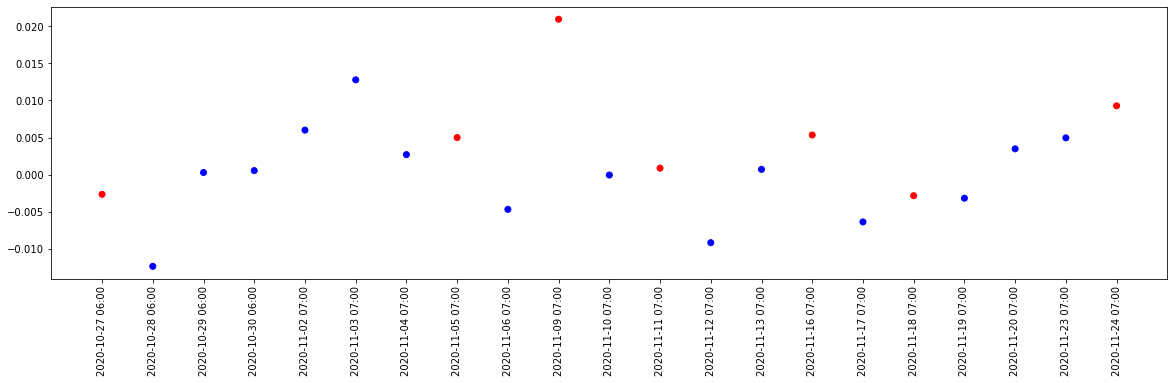

[0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0]
money: CAD_JPY
NOW Data from30days ago
 LOW/MID/HIGH
[12, 10]

test data
['2020-10-27 06:00'] to ['2020-11-25 07:00']

CAD_JPY_AdaBoost_1500.sav
accuracy_score: 0.5714285714285714
precision_score: [0.625      0.53846154]
[[5 6]
 [3 7]]
[-0.57142857  0.57142857  0.57142857  0.57142857  0.57142857  0.57142857
 -0.57142857  0.57142857  0.57142857  0.57142857  0.57142857  0.57142857
 -0.57142857 -0.57142857  0.57142857 -0.57142857 -0.57142857  0.57142857
  0.57142857 -0.57142857 -0.57142857]
CAD_JPY_AdaBoost_2000.sav
accuracy_score: 0.5714285714285714
precision_score: [0.6        0.54545455]
[[6 5]
 [4 6]]
[-0.57142857  0.57142857  0.57142857  0.57142857  0.57142857  0.57142857
 -0.57142857  0.57142857  0.57142857  0.57142857  0.57142857  0.57142857
 -0.57142857 -0.57142857 -0.57142857 -0.57142857 -0.57142857  0.57142857
 -0.57142857 -0.57142857 -0.57142857]
CAD_JPY_AdaBoost_500.sav
accuracy_score: 0.8095238095238095
precision

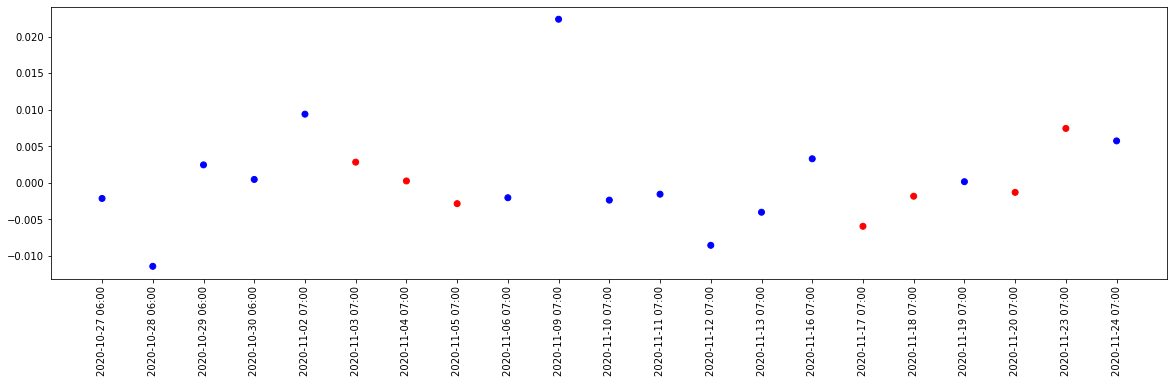

[1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1]
money: CHF_JPY
NOW Data from30days ago
 LOW/MID/HIGH
[13, 9]

test data
['2020-10-27 06:00'] to ['2020-11-25 07:00']

CHF_JPY_AdaBoost_1000.sav
accuracy_score: 0.6666666666666666
precision_score: [0.64705882 0.75      ]
[[11  1]
 [ 6  3]]
[ 0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667  0.66666667
 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667
 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667  0.66666667
  0.66666667 -0.66666667 -0.66666667]
CHF_JPY_AdaBoost_500.sav
accuracy_score: 0.6666666666666666
precision_score: [0.72727273 0.6       ]
[[8 4]
 [3 6]]
[ 0.66666667 -0.66666667 -0.66666667 -0.66666667  0.66666667  0.66666667
 -0.66666667 -0.66666667  0.66666667 -0.66666667 -0.66666667  0.66666667
  0.66666667 -0.66666667  0.66666667 -0.66666667  0.66666667  0.66666667
 -0.66666667  0.66666667 -0.66666667]
CHF_JPY_Decision Tree_500.sav
accuracy_score: 0.7142857142857143
pr

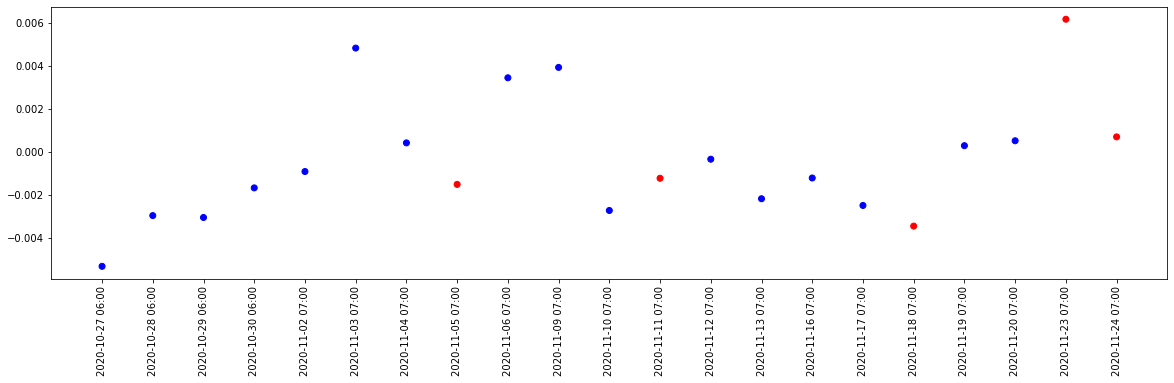

[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0]


In [2]:
# -*- coding: utf-8 -*-
from oandapyV20 import API
from oandapyV20.exceptions import V20Error
from oandapyV20.endpoints.pricing import PricingStream
import oandapyV20.endpoints.orders as orders
import oandapyV20.endpoints.instruments as instruments

import json
import datetime
import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta

import time

get_ipython().run_line_magic('matplotlib', 'inline')
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
import pickle
import math
import glob
import talib as ta

#自分のアカウント、トークンをセット
accountID = "101-009-16415310-001"
access_token = '860c2d2dbbcd01b6d95939b6af6b5981-8664724ce0870220c55161d704137df6'

api = API(access_token=access_token, environment="practice")
        
# Oandaからcandleデータを取得する。
def getCandleDataFromOanda(instrument, api, date_from, date_to, granularity):
    params = {
        "from": date_from.isoformat(),
        "to": date_to.isoformat(),
        "granularity": granularity,
    }
    r = instruments.InstrumentsCandles(instrument=instrument, params=params)
    return api.request(r)

def oandaJsonToPythonList(JSONRes):
    
    data = []
    for res in JSONRes['candles']:
        temp = [((datetime.datetime.fromisoformat(res['time'][:19]))+datetime.timedelta(hours=+9)).strftime('%Y-%m-%d %H:%M')]#indexとなる時間を追加
        temp.extend([res['volume'],
            res['mid']['o'],
            res['mid']['h'],
            res['mid']['l'],
            res['mid']['c'],
            ])
        data.append(temp)
    return data

def logarism(x):
    return math.log(x)


def get_now_data(time, period_Days, money='USD_JPY', foot = 'D', back_days = 0):
    
    all_data = []
    time = time.replace(hour=7, minute=0, second=0, microsecond=0)
    #入力された日の当日の7時
    
    NY = datetime.timedelta(hours=-14)
    back = datetime.timedelta(days=-back_days)
    
    date_to = time + NY + datetime.timedelta(seconds=0) + back
    date_from = date_to + datetime.timedelta(days=-period_Days)
#     date_from = date_to + datetime.timedelta(days=-(period_Days+100))
    
    ret = getCandleDataFromOanda(money, api, date_from, date_to, foot)
    month_data = oandaJsonToPythonList(ret)#取得したデータを格納

    all_data.extend(month_data)#データを追加

    # pandas DataFrameへ変換
    df = pd.DataFrame(all_data)

    df.columns = ['Datetime','Volume', 'Open', 'High', 'Low', 'Close']
    df['Open'] = df['Open'].astype('double')
    df['Close'] = df['Close'].astype('double')
    
    
    close = np.array(df["Close"]).astype(float)
    #以下、talibを用いてテクニカル指標（今回の学習で用いる特徴量）を算出しdf_feature入れる
    #単純移動平均は、単純移動平均値とその日の終値の比を特徴量として用いる
    #df["SMA5"]= ta.SMA(close, timeperiod=5) / close
    #df["SMA10"]= ta.SMA(close, timeperiod=10) / close
    #ボリンジャーバンド 
#     upper, middle, lower = ta.BBANDS(close, timeperiod=20, nbdevup=2, nbdevdn=2)
#     df["BBANDS+2σ"] = upper / close
#     df["BBANDS-2σ"] = lower / close
    
    
#     df['Open'] = df['Open'].apply(lambda x: logarism(x))
#     df['Close'] = df['Close'].apply(lambda x: logarism(x))
    
    df['Rate']=(df['Close']-df['Open'])/df['Open']
    
    df = df.dropna()
    
    df = df.set_index('Datetime')
    
    
    
    return df
    
def get_csv(back_days=100, days=3650, money='USD_JPY'):
    time = datetime.datetime.now()
    df = get_now_data(time, period_Days=days, money=money, foot = 'D', back_days=back_days)
    date_to = (time+datetime.timedelta(days=-back_days)+datetime.timedelta(days=-1)).strftime("%Y-%m-%d")
    date_from = (time + datetime.timedelta(days=-days)+datetime.timedelta(days=-back_days)).strftime("%Y-%m-%d")
    df.to_csv(str(money)+"_"+ date_from + "_" + date_to +"_"+str(days)+'.csv', mode = 'w')
    print('"'+str(money)+"_"+ date_from + "_" + date_to +"_"+str(days)+'.csv', end='", ')
    
    return df

def get_moneys_csv(back_days, days, moneylist):
    csvlist = []
    time = datetime.datetime.now()
    date_to = (time+datetime.timedelta(days=-back_days)+datetime.timedelta(days=-1)).strftime("%Y-%m-%d")
    date_from = (time + datetime.timedelta(days=-days)+datetime.timedelta(days=-back_days)).strftime("%Y-%m-%d")
    
    for i in range (len(moneylist)):
        get_csv(back_days, days, money=moneylist[i])
        csvlist.extend([str(moneylist[i])+"_"+ date_from + "_" + date_to +"_"+str(days)+'.csv'])
    
    return csvlist
        
def classify_two(x, c):
        if x<=0:
            c[0]+=1
            return -1
        elif 0<x:
            c[1]+=1
            return 1

def predict(dataname, moneyname, test_days, back_day, datanum):

    df = pd.read_csv(dataname, index_col='Datetime')
    
    count = [0,0]
    #df['class'] = (df["Rate"]).apply(lambda x: classify(x, count, 0.001))
    df['class'] = (df["Rate"]).apply(lambda x: classify_two(x, count))
    df['class'] = df['class'].shift(-1)
    print("Train Data")
    print(" LOW/HIGH")
    print(count)
    
    X = df.drop('class', axis=1)
    y = df['class']
    X = X.drop(X.index[len(X)-1])
    y = y.dropna()
    
    df_now = get_now_data(datetime.datetime.now(), period_Days=test_days, money=moneyname, foot = 'D', back_days = back_day)
    
    print("money: "+moneyname)
    count = [0,0]
    #df['class'] = (df["Rate"]).apply(lambda x: classify(x, count, 0.001))
    df_now['class'] = (df_now["Rate"]).apply(lambda x: classify_two(x, count))
    df_now['class'] = df_now['class'].shift(-1)
    print("NOW Data from" +str(test_days)+ "days ago")
    print(" LOW/MID/HIGH")
    print(count)
    
    print("learning data")
    print(df.head(1).index.values, end=' to ')
    print(df.tail(1).index.values)
    
    print("")
    print("test data")
    print(df_now.head(1).index.values,end=' to ')
    print(df_now.tail(1).index.values)
    print("")
    X_now = df_now.drop('class', axis=1)
    
    X_next = X_now.tail(1) #最終予測に利用
    y_now = df_now['class']
    X_now = X_now.drop(X_now.index[len(X_now)-1])
    y_now = y_now.dropna()
    
    X_train = X
    y_train = y
    X_test = X_now
    y_test = y_now
    
    
    names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Decision Tree",
             "Random Forest", "AdaBoost", "Naive Bayes", "Linear Discriminant Analysis",
             "Quadratic Discriminant Analysis"]
    classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=10),
    RandomForestClassifier(max_depth=10, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]
    
    accuracy_scores = []
    precision_scores = []
    next_class = []
    profit = []
    
    clearlist = []
    
    for name, clf in zip(names, classifiers):
        print(name)
        clf.fit(X_train, y_train)
        result = clf.predict(X_test)
        profit, values = calc_profit(result, y_test)
        precision = precision_score(y_test, result, average=None)
        accuracy = accuracy_score(y_test, result)
        if(precision[0]>0.45 and precision[1]>0.45 and precision[0]!=1 and precision[1]!=1 and accuracy>0.55):
        #if(precision[0]>0.4 and precision[1]>0.4):
#             score = clf.score(X_test, y_test)
            next_class.extend(clf.predict(X_next))

            print('accuracy_score: ', end='')
            print(accuracy_score(y_test, result))
            accuracy_scores.extend([accuracy_score(y_test, result)])
            print('confusion_matrix: ')
            print(confusion_matrix(y_test, result))
            print('precision_score: ', end='')
            print(precision_score(y_test, result, average=None))
            precision_scores.extend([precision_score(y_test, result, average=None)])

            print(str(len(result))+"days trade")
            print("profit: "+str(profit))

            print('')

            model_name = moneyname + "_" + name + "_" + str(datanum) +".sav"
            #clearlist.extend([model_name])
            print("CLEAR: " + model_name)
            pickle.dump(clf, open(model_name, 'wb'))

    #print(clearlist)
    return accuracy_scores, precision_scores, next_class, profit

def make_models(test_days, namelist, moneylist, back_days, datanum):
    for i in range(len(namelist)):
        print(namelist[i])
        acc, pre, next_class, profit = predict(namelist[i], moneylist[i], test_days, back_days, datanum)
        print(acc)


def calc_profit(predict_result, true_data):
    win=0
    lose=0
    for i in range(len(predict_result)):
            if (predict_result[i]==-1):#Low予想のとき
                if (predict_result[i]==true_data[i]): #予測成功
                    win+=1
                else:
                    lose+=1
            elif(predict_result[i]==1):#High予想の時
                if (predict_result[i]==true_data[i]): #予測成功
                    win+=1
                else:
                    lose+=1
    profit = win*0.95-lose #利率を算出
    values = predict_result*profit #予測結果×利率により予測の価値を算出
    return profit, values

def plot_result(index, predict_result, true_data):
    plt.figure(figsize=(20,5))
    index = index.astype(float)

    color = []
    marker = []
    accuracy = []
    
    for x in range(0,len(predict_result)):
        if true_data.values[x] == predict_result[x]:
            color.extend(['blue'])
            accuracy.extend([1])

        else:
            color.extend(['red'])
            accuracy.extend([0])


    plt.scatter(index.index.values, index["Rate"].values, color=color)

    plt.xticks(rotation=90)
    plt.show()
    
    return accuracy


def ensemble(model_names, moneyname, days):
    
    df_now = get_now_data(datetime.datetime.now(), period_Days=days, money=moneyname, foot = 'D', back_days = NIGHT)###########
    print("money: "+moneyname)
    count = [0,0]
    
    df_now['class'] = (df_now["Rate"]).apply(lambda x: classify_two(x, count))
    df_now['class'] = df_now['class'].shift(-1)
    print("NOW Data from" +str(days)+ "days ago")
    print(" LOW/MID/HIGH")
    print(count)

    print("")
    print("test data")
    print(df_now.head(1).index.values,end=' to ')
    print(df_now.tail(1).index.values)
    print("")
    X_now = df_now.drop('class', axis=1)
    
    X_next = X_now.tail(1) #最終予測に利用
    y_now = df_now['class']
    X_now = X_now.drop(X_now.index[len(X_now)-1])
    y_now = y_now.dropna()
    
    values = []
    values_sum = []
    win=0
    lose=0
    answer = 0
    
    for x in range(len(model_names)):
        clf = pickle.load(open(model_names[x], 'rb')) #clfをload
        print(model_names[x])
        result = clf.predict(X_now) #predict
        
        precision = precision_score(y_now, result, average=None)
        #if(precision[0]>0.5 and precision[1]>0.5):
       
        #score表示
        print("accuracy_score: ", end="")
        print(accuracy_score(y_now, result))
        print("precision_score: ", end="")
        print(precision)
        print(confusion_matrix(y_now, result))

        profit, values = calc_profit(result, y_now) #予測結果について利率と、予測*利率による予測の信頼性を算出

        #answer += clf.predict(X_next)[0]*profit
        answer += clf.predict(X_next)[0]*accuracy_score(y_now, result)
        values = result*accuracy_score(y_now, result)
        if len(values_sum)==0:#1回目は配列をコピー
            values_sum = values
        else:
            values_sum += values #２回目からは加算
        print(values)
    
        #plot_result(X_now, result, y_now)
        
    print(values_sum)
    ensemble_result = np.where(values_sum<0, -1, 1) #クラス分類
    
    print("")
    print("ensemble_result: ",end='')
    print(accuracy_score(y_now.values, ensemble_result))
    print(ensemble_result)
    print(y_now.values)
    print(values_sum)
    print("precision_score: ", end="")
    print(precision_score(y_now, ensemble_result, average=None))
    print('confusion_matrix: ')
    print(confusion_matrix(y_now, ensemble_result))
    print("profit: ",end='')
    profit, values = calc_profit(ensemble_result, y_now)
    print(profit)
    print("next: ",end='')
    print(answer)
    if(answer>0):
        print("HIGH")
    else:
        print("LOW")
    print(X_next.head(1))
    accuracy = plot_result(X_now, ensemble_result, y_now)
    
    return accuracy
        
    
def compere_ensemble(models_array, moneys_array, days):
    results = []
    
    for i in range(len(moneys_array)):
        results.append(np.array(ensemble(models_array[i], moneys_array[i], days)).astype('int'))
    
    np.savetxt('out.csv',results,delimiter=',')
    print(results)
    
def ensemble_set(models_array, moneys_array, days):
    
    for i in range(len(models_array)):
        print(ensemble(models_array[i], moneys_array[i], days))
        
def plot_rates(days, moneys):
    
    result = []
    accord = []
    plt.figure(figsize=(40,20))
    for i in range(len(moneys)):
        df_now = get_now_data(datetime.datetime.now(), period_Days=days, money=moneys[i], foot = 'D', back_days = 0)
        plt.plot(df_now.index.values, df_now["Rate"].values)
        count = [0,0]
        df_now['class'] = (df_now["Rate"]).apply(lambda x: classify_two(x, count))
        result.append(df_now["class"].values)
    
    win = 0
    lose = 0
    
    for l in range(len(result[0])):
        temp = 0
        for m in range(len(moneys)):
            if result[m][l]==1:
                temp+=1
        if(temp==len(moneys)/2):
            accord.extend([-1])
            lose += len(moneys)/2
            win += len(moneys)/2
        else:
            accord.extend([temp])
            win += max(temp, len(moneys)-temp)
            lose += min(temp, len(moneys)-temp)
    
    
    plt.xticks(rotation=90)
    plt.hlines([0], 0, days, "blue", linestyles='dashed')     # hlines
    plt.show()
    print(accord)
    
    pay = 1000
    pay_sum = pay*len(moneys)
    
    print("win: ", win)
    print("lose: ", lose)
    print("rate: ", win/(win+lose))
    print("profit: ", (win*0.95-lose)*pay_sum)
    
def main():
    
    AUD_models = glob.glob('AUD_JPY*.sav')
    
    CAD_models = glob.glob('CAD_JPY*.sav')
    
    CHF_models = glob.glob('CHF_JPY*.sav')
    
    models = [AUD_models, CAD_models, CHF_models]
    moneys = ["AUD_JPY", "CAD_JPY", "CHF_JPY"]
    
    #ensemble(CHF_models, "CHF_JPY", 60)   #選択した通貨に対してアンサンブル
    #compere_ensemble(models, moneys, 30)   #それぞれの通貨に対してアンサンブルした結果をcsvに返す
    #plot_rates(30,moneys)
    ensemble_set(models, moneys, 30)  #指定したmoneyで結果を出す
    
def get_csv_and_make_models():
    
    moneylist=['AUD_JPY', 'CAD_JPY', 'CHF_JPY']
    #array100 = get_moneys_csv(back_days=91, days=100)
    array500 = get_moneys_csv(back_days=32, days=500, moneylist = moneylist) # 指定期間のcsvをsave
    array1000 = get_moneys_csv(back_days=32, days=1000, moneylist = moneylist)
    array1500 = get_moneys_csv(back_days=32, days=1500, moneylist = moneylist)
    array2000 = get_moneys_csv(back_days=32, days=2000, moneylist = moneylist)
   #make_models(test_days, namelist, moneylist, back_days, datanum):
    #make_models(60, array100, moneylist, 0, 100)
    
    make_models(30, array500, moneylist, 0, 500)
    make_models(30, array1000, moneylist, 0, 1000)
    make_models(30, array1500, moneylist, 0, 1500)
    make_models(30, array2000, moneylist, 0, 2000)

NIGHT = 0
    
#get_csv_and_make_models()

main()





